# Mars Surface and Curiosity Image Classification
### Using a convolutional neural network

by Zachary Pruessner, for Springboard Final submission

**Dataset DOI**

10.5281/zenodo.1049137

**Scientific Paper with additional details on the data** 

Kiri L. Wagstaff, You Lu, Alice Stanboli, Kevin Grimes, Thamme Gowda,
and Jordan Padams. "Deep Mars: CNN Classification of Mars Imagery for
the PDS Imaging Atlas." Proceedings of the Thirtieth Annual Conference
on Innovative Applications of Artificial Intelligence, 2018.


-

List of Labels


- 0       apxs
- 1       apxs cal target
- 2       chemcam cal target
- 3       chemin inlet open
- 4       drill
- 5       drill holes
- 6       drt front
- 7       drt side
- 8       ground
- 9       horizon
- 10      inlet
- 11      mahli
- 12      mahli cal target
- 13      mastcam
- 14      mastcam cal target
- 15      observation tray
- 16      portion box
- 17      portion tube
- 18      portion tube opening
- 19      rems uv sensor
- 20      rover rear deck
- 21      scoop
- 22      sun
- 23      turret
- 24      wheel



### Imports

In [1]:
# Imports

# Standard
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Pathing
import os

# Image Processing
import cv2

# Transformations
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Metrics

# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

### Loading Data

In [2]:
# loading in the image path and label csv files
test = pd.read_csv('..\data\Test_CSV.csv')
train = pd.read_csv('..\data\Train_CSV.csv')
val = pd.read_csv('..\data\Validation_CSV.csv')

# displaying the layout of the tables
print(test.head(), '\n', train.head(), '\n',  val.head())

# checking the shape
print(' Test shape: ', test.shape, '\n', 'Train shape: ', train.shape, '\n', 'Val shape: ', val.shape )

                                             JPG  LABELS
0  calibrated/0830MR0036510000500684E01_DRCL.JPG       7
1  calibrated/0640MH0002640000203781I01_DRCL.JPG      24
2  calibrated/0647MH0003250050203806E01_DRCL.JPG       9
3  calibrated/0844MR0037590000501001I01_DRCL.JPG       7
4  calibrated/0618MR0026460020401253I01_DRCL.JPG      11 
                                              JPG  LABELS
0  calibrated/0077ML0005780000102730I01_DRCL.JPG      15
1  calibrated/0072MR0005610170103642E01_DRCL.JPG       8
2  calibrated/0069MR0004130000103477I01_DRCL.JPG      21
3  calibrated/0154ML0008510010104492E01_DRCL.JPG       8
4  calibrated/0019MR0000530000100138C00_DRCL.JPG       8 
                                              JPG  LABELS
0  calibrated/0292MH0002810020103587C00_DRCL.JPG       5
1  calibrated/0270MH0002530050102760I01_DRCL.JPG       5
2  calibrated/0549MH0002620000201566E01_DRCL.JPG      24
3  calibrated/0229MR0009720000202913E01_DRCL.JPG       0
4  calibrated/0292MH0002810

### Cleaning Data

The csv files only reference 6691 of the 39059 images available. These images reside in the images folder. The other 32368 reside in the folder labeled additional_images.

For now I will focus on using the images referenced in the tables.

The original data has the files paths set differently than what is on my system. Therefore the files paths in the csv files will need to be corrected.

My folder structure is:
```
final_capstone
    |data
        |additional_images
        |images
    |dev
        |mars_curiosity_eda.ipynb
    |dist
```

The new pathing will be '../data/images' followed by the image name

In [3]:
# helper function for correcting the pathing in the csv files
def modify_path(path_col, splitter='calibrated'):
    new_path_list = []
    for row in path_col:
        old_path, image_id = row.split(splitter)
        new_path = '../data/images' + str(image_id)
        new_path_list.append(new_path)
    return new_path_list

In [4]:
# reframing
frames = [train, test, val]

# joining into single df
mars = pd.concat(frames)
mars.shape

# using modify_path to correct the path values in the JPG column
mars['JPG'] = modify_path(mars['JPG'])

### Data Split

In [5]:
X_train, X_test = train_test_split(mars, train_size=0.9, random_state=42, shuffle=True)

# checking shape of train and test split
print(X_train.shape)
print(X_test.shape)

# showing distribution of classes
print(X_train.LABELS.value_counts())

(6021, 2)
(670, 2)
8     2416
24     899
5      464
9      319
10     244
21     183
23     174
3      152
14     146
7      144
17     124
12     108
15     101
16      75
0       68
20      66
13      62
19      61
6       60
4       55
2       35
11      24
1       23
18      18
Name: LABELS, dtype: int64


There is a large concentration in the label 8. This is the ground label. 24 is the next highest concentration, the wheel label.

### Image Transformation

In [6]:
# Transforming train images
Transformed_X_Train = []
Transformed_X_Train_Labels = []

for image, label in zip(X_train.JPG, X_train.LABELS):
    image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(256,256))
    image = image / 255.0
    Transformed_X_Train.append(image)
    Transformed_X_Train_Labels.append(label)
    
X_Train_Img = np.array(Transformed_X_Train)
X_Train_Labels = to_categorical(Transformed_X_Train_Labels)

# Checking shape
print(X_Train_Img.shape)
print(X_Train_Labels.shape)

(6021, 256, 256, 3)
(6021, 25)


In [7]:
# Transforming test images
Transformed_X_Test = []
Transformed_X_Test_Labels = []

for image, label in zip(X_test.JPG, X_test.LABELS):
    image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(256,256))
    image = image / 255.0
    Transformed_X_Test.append(image)
    Transformed_X_Test_Labels.append(label)
    
X_Test_Img = np.array(Transformed_X_Test)
X_Test_Labels = to_categorical(Transformed_X_Test_Labels)

# Checking shape
print(X_Test_Img.shape)
print(X_Test_Labels.shape)

(670, 256, 256, 3)
(670, 25)


### Modeling

In [8]:
# building model architecture
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(25, activation='softmax')
])

In [9]:
# preparing log functionality
root_logdir = os.path.join(os.curdir, "logs\\fit\\")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [10]:
# compiling model using categorical_crossentropy for the loss function and adam as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                        

### Training

In [11]:
# training the model with 50 epocs, and a batch size of 64, and a validation split of 90%
fitted_model = model.fit(X_Train_Img, X_Train_Labels, 
                         epochs=50, 
                         batch_size=64,
                         validation_split=0.1,
                         callbacks=[tensorboard_cb])

Epoch 1/50
85/85 [==============================] - 252s 3s/step - loss: 6.3546 - accuracy: 0.5808 - val_loss: 5.2889 - val_accuracy: 0.1144
Epoch 2/50
85/85 [==============================] - 245s 3s/step - loss: 1.1924 - accuracy: 0.7224 - val_loss: 1.2632 - val_accuracy: 0.6153
Epoch 3/50
85/85 [==============================] - 243s 3s/step - loss: 1.0338 - accuracy: 0.7706 - val_loss: 1.0159 - val_accuracy: 0.7015
Epoch 4/50
85/85 [==============================] - 243s 3s/step - loss: 0.8781 - accuracy: 0.7894 - val_loss: 0.8368 - val_accuracy: 0.8292
Epoch 5/50
85/85 [==============================] - 243s 3s/step - loss: 0.8160 - accuracy: 0.8247 - val_loss: 0.6519 - val_accuracy: 0.8425
Epoch 6/50
85/85 [==============================] - 242s 3s/step - loss: 0.7449 - accuracy: 0.8400 - val_loss: 0.9772 - val_accuracy: 0.8126
Epoch 7/50
85/85 [==============================] - 243s 3s/step - loss: 0.7348 - accuracy: 0.8494 - val_loss: 0.6177 - val_accuracy: 0.8259
Epoch 8/50
85

In [12]:
model.save('../dist/model')

INFO:tensorflow:Assets written to: ../dist/model\assets


### Prediction

In [13]:
# loading a small portion of the prediction
Test_Prediction_10 = model(X_Test_Img[0:10])

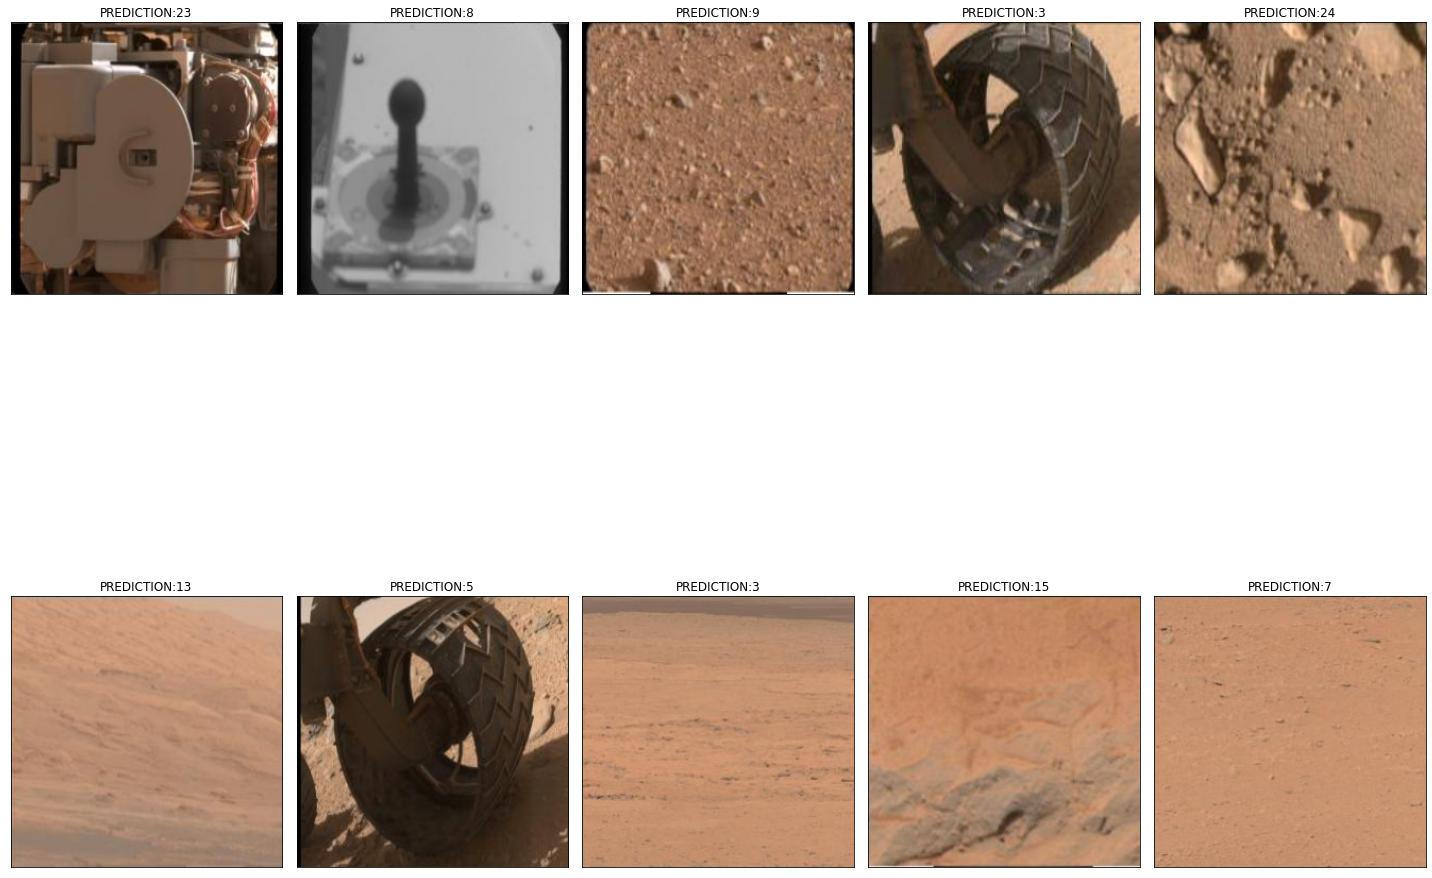

In [14]:
# visualizing the prediction results
fig, axes = plt.subplots(nrows=2,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Transformed_X_Train[i])
    ax.set_title(f"PREDICTION:{Test_Prediction_10[i].numpy().argmax(axis=-1)}")
plt.tight_layout()
plt.show()

In [15]:
# loading full prediction set
Test_Prediction = model.predict(X_Test_Img)

# predict labels
predict_labels = Test_Prediction.argmax(axis=-1)

# actual labels
actual_labels = X_Test_Labels.argmax(axis=-1)

# checking for same length
print(len(predict_labels))
print(len(actual_labels))

670
670


In [16]:
# checking difference between prediction and actual
set_difference = set(actual_labels) - set(predict_labels)
list_difference = list(set_difference)
print(list_difference)

print(1 - (len(list_difference)/len(actual_labels)) * 100)

[]
1.0
